In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, \
show_summaries, get_base_predictions, get_multi_base_predictions
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_ensemble

In [2]:
cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

In [3]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    results = IO(data_dir + 'results/results.pkl').read_pickle()
    is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()

    ys_base_train, ys_base_test, ys_base_cv, weights = get_base_predictions(results, is_successful, datanames, thres=0.05)
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()
    data_split = [ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights]
    IO(data_dir + '061_data_split.pkl').to_pickle(data_split)
    
    results = [IO(data_dir + 'results/results.pkl').read_pickle(), IO(data_dir + 'results05/results.pkl').read_pickle()]
    is_successful = [IO(data_dir + 'results/is_successful.pkl').read_pickle(), \
                     IO(data_dir + 'results05/is_successful.pkl').read_pickle()]
    datanames = [IO(data_dir + 'results/datanames.pkl').read_pickle(), \
                 IO(data_dir + 'results05/datanames.pkl').read_pickle()]
    ys_base_train, ys_base_test, ys_base_cv, weights = \
    get_multi_base_predictions(results, is_successful, datanames, thres=0.05)
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()
    data_split = [ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights]
    IO(data_dir + '062_data_split.pkl').to_pickle(data_split)

Champaign...
Cleveland...
Pittsburgh...
Toronto...
Las_Vegas...
Full...
Wall time: 1min 59s


In [4]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    models = [RS_ensemble(estimator=None), RS_ensemble(estimator=RidgeCV()), \
              RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3)), \
              RS_ensemble(estimator=None), RS_ensemble(estimator=RidgeCV()), \
              RS_ensemble(estimator=RandomForestRegressor(n_estimators=50, max_depth=3))]
    switch = [False, False, False, True, False, False]
    model_names = ['Ensemble1 (weighted average)', 'Ensemble1 (Ridge regression)', 'Ensemble1 (random forest)', \
                   'Ensemble2 (weighted average)', 'Ensemble2 (Ridge regression)', 'Ensemble2 (random forest)']
    datanames = [data_dir + 'results06/' + str(i) + '.pkl' for i in range(len(models))]
    
    IO(data_dir + 'results06/models.pkl').to_pickle(models)
    IO(data_dir + 'results06/model_names.pkl').to_pickle(model_names)
    IO(data_dir + 'results06/switch.pkl').to_pickle(switch)
    IO(data_dir + 'results06/datanames.pkl').to_pickle(datanames)

Champaign...
Cleveland...
Pittsburgh...
Toronto...
Las_Vegas...
Full...
Wall time: 46 ms


In [5]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    
    is_successful = []
    
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    models = IO(data_dir + 'results06/models.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    switch = IO(data_dir + 'results06/switch.pkl').read_pickle()
    
    ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
    IO(data_dir + '061_data_split.pkl').read_pickle()
    
    for i, model in enumerate(models):
        if switch[i]:
            ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
            IO(data_dir + '062_data_split.pkl').read_pickle()
        try:
            print(model_names[i] + '...')
            model.fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
            print(model_names[i] + 'fitting successful.')
            IO(datanames[i]).to_pickle(model)
            print('Saving to pickle successful.')
            del model
            is_successful.append(True)
            print()
        except:
            traceback.print_exc()
            print('Failed.')
            is_successful.append(False)
            print()
            
    IO(data_dir + 'results06/is_successful.pkl').to_pickle(is_successful)

Champaign...
Ensemble1 (weighted average)...
Ensemble1 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble1 (Ridge regression)...
Ensemble1 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble1 (random forest)...
Ensemble1 (random forest)fitting successful.
Saving to pickle successful.

Ensemble2 (weighted average)...
Ensemble2 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble2 (Ridge regression)...
Ensemble2 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble2 (random forest)...
Ensemble2 (random forest)fitting successful.
Saving to pickle successful.

Cleveland...
Ensemble1 (weighted average)...
Ensemble1 (weighted average)fitting successful.
Saving to pickle successful.

Ensemble1 (Ridge regression)...
Ensemble1 (Ridge regression)fitting successful.
Saving to pickle successful.

Ensemble1 (random forest)...
Ensemble1 (random forest)fitting successful.
Saving to pickle successful.

En

In [6]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    switch = IO(data_dir + 'results06/switch.pkl').read_pickle()
    ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
    IO(data_dir + '061_data_split.pkl').read_pickle()
    
    results = []
    for i in range(len(is_successful)):
        print(model_names[i] + '...')
        if switch[i]:
            ys_base_train, y_train, ys_base_test, y_test, ys_base_cv, y_cv, weights = \
            IO(data_dir + '062_data_split.pkl').read_pickle()
        if not is_successful[i]:
            results.append(None)
        else:
            model = IO(datanames[i]).read_pickle()
            results.append(get_results(model, X_train=ys_base_train, y_train=y_train, X_test=ys_base_test, y_test=y_test, \
                                       X_cv=ys_base_cv, y_cv=y_cv))
            del model
        
    print('Done.')
    IO(data_dir + 'results06/results.pkl').to_pickle(results)
    print()

Champaign...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Cleveland...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Pittsburgh...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Toronto...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensemble2 (random forest)...
Done.

Las_Vegas...
Ensemble1 (weighted average)...
Ensemble1 (Ridge regression)...
Ensemble1 (random forest)...
Ensemble2 (weighted average)...
Ensemble2 (Ridge regression)...
Ensembl

In [7]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results06/results.pkl').read_pickle()
    is_successful = IO(data_dir + 'results06/is_successful.pkl').read_pickle()
    sizes = IO(data_dir + 'sizes.pkl').read_pickle()

    display(Markdown('## {} <sup>({} reviews, {} restaurants, {} users)</sup>'.\
                     format(city, sizes[0], sizes[1], sizes[2])))
    display(Markdown('**Ensemble**'))
    show_summaries(model_names, results, is_successful)
    display(Markdown('<sup>(Ensemble1 represents the ensemble of collaborative filtering models; \
    Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>'))

Champaign...


## Champaign <sup>(20571 reviews, 878 restaurants, 8451 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.000,0.8527,1.3071,0.6454,0.1882
Ensemble1 (Ridge regression),0.011,1.3268,1.3026,0.1413,0.1937
Ensemble1 (random forest),0.220,1.0506,1.3048,0.4617,0.1910
Ensemble2 (weighted average),0.000,0.9007,1.1591,0.6043,0.3616
Ensemble2 (Ridge regression),0.004,1.2721,1.0830,0.2107,0.4426
Ensemble2 (random forest),0.271,1.0678,1.0847,0.4439,0.4409


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Cleveland...


## Cleveland <sup>(75932 reviews, 2500 restaurants, 30131 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7559,1.2085,0.6839,0.1955
Ensemble1 (Ridge regression),0.0050,0.9587,1.2040,0.4916,0.2014
Ensemble1 (random forest),0.7260,0.9431,1.2063,0.5080,0.1984
Ensemble2 (weighted average),0.0000,0.8214,1.0915,0.6268,0.3437
Ensemble2 (Ridge regression),0.0070,1.0072,1.0141,0.4389,0.4334
Ensemble2 (random forest),0.9471,0.9989,1.0180,0.4480,0.4291


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Pittsburgh...


## Pittsburgh <sup>(143682 reviews, 4745 restaurants, 46179 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.8050,1.1919,0.6317,0.1925
Ensemble1 (Ridge regression),0.0150,0.9371,1.1872,0.5010,0.1988
Ensemble1 (random forest),1.2871,0.9703,1.1882,0.4650,0.1974
Ensemble2 (weighted average),0.0000,0.8576,1.0612,0.5820,0.3598
Ensemble2 (Ridge regression),0.0170,0.9494,0.9882,0.4878,0.4449
Ensemble2 (random forest),1.7071,0.9996,0.9933,0.4322,0.4391


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Toronto...


## Toronto <sup>(331407 reviews, 12118 restaurants, 77506 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.8044,1.1661,0.6136,0.1837
Ensemble1 (Ridge regression),0.0290,1.0152,1.1620,0.3845,0.1895
Ensemble1 (random forest),3.2312,0.9977,1.1637,0.4056,0.1872
Ensemble2 (weighted average),0.0000,0.8564,1.0542,0.5620,0.3329
Ensemble2 (Ridge regression),0.0390,1.0111,0.9879,0.3895,0.4141
Ensemble2 (random forest),4.1512,0.9948,0.9962,0.4090,0.4043


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Las_Vegas...


## Las_Vegas <sup>(1280896 reviews, 20434 restaurants, 429363 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.7633,1.2648,0.7185,0.2270
Ensemble1 (Ridge regression),0.1270,1.0514,1.2600,0.4660,0.2329
Ensemble1 (random forest),13.2948,1.0838,1.2617,0.4326,0.2308
Ensemble2 (weighted average),0.0000,0.8674,1.1697,0.6366,0.3389
Ensemble2 (Ridge regression),0.1520,1.1144,1.1016,0.4001,0.4136
Ensemble2 (random forest),16.9300,1.1061,1.1082,0.4090,0.4066


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Full...


## Full <sup>(4166778 reviews, 131025 restaurants, 1117891 users)</sup>

**Ensemble**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ensemble1 (weighted average),0.0000,0.8161,1.2572,0.6706,0.2195
Ensemble1 (Ridge regression),0.4160,1.0550,1.2520,0.4496,0.2260
Ensemble1 (random forest),56.0282,1.0652,1.2542,0.4389,0.2233
Ensemble2 (weighted average),0.0000,0.8864,1.1434,0.6115,0.3545
Ensemble2 (Ridge regression),0.5530,1.0865,1.0623,0.4163,0.4427
Ensemble2 (random forest),69.6950,1.0689,1.0703,0.4351,0.4343


<sup>(Ensemble1 represents the ensemble of collaborative filtering models;     Ensemble2 represents the ensemble of collaborative filtering and content filtering models)</sup>

Wall time: 522 ms


Champaign...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8527.  
            RMSE on test set: 1.3071.  
            $R^2$ on training set: 0.6454.   
            $R^2$ on test set: 0.1882.  
            Classification accuracy on training set: 0.3950.  
            Classification accuracy on test set: 0.2535.
            

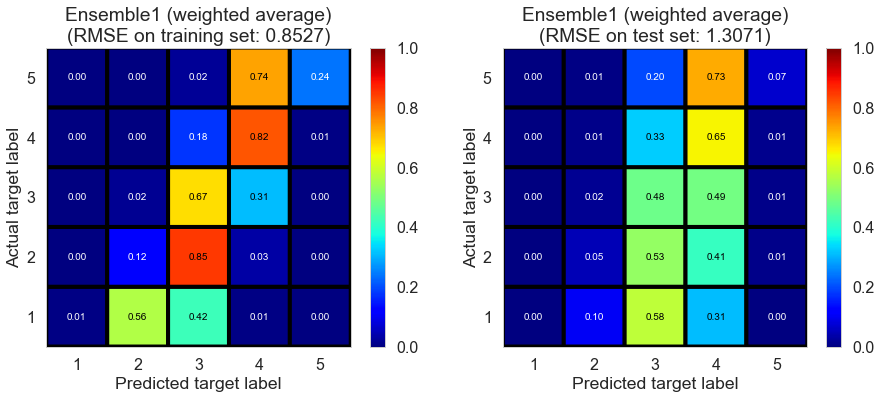

### Ensemble1 (Ridge regression)

Fitting time: 0.0110 s.  
            RMSE on training set: 1.3268.  
            RMSE on test set: 1.3026.  
            $R^2$ on training set: 0.1413.   
            $R^2$ on test set: 0.1937.  
            Classification accuracy on training set: 0.2315.  
            Classification accuracy on test set: 0.2558.
            

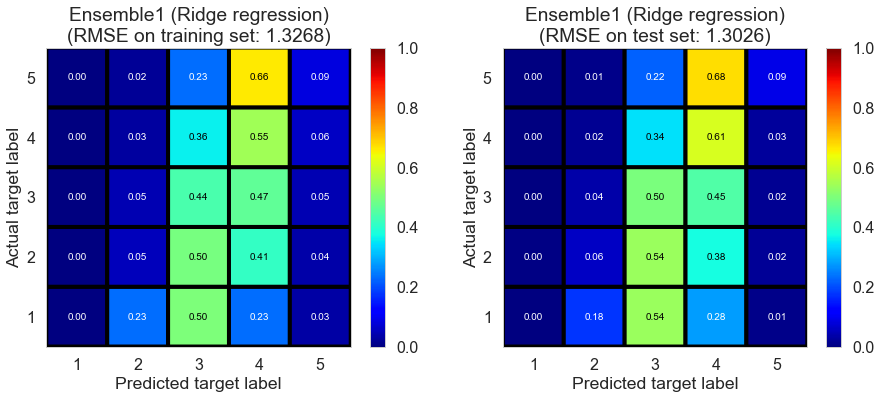

### Ensemble1 (random forest)

Fitting time: 0.2200 s.  
            RMSE on training set: 1.0506.  
            RMSE on test set: 1.3048.  
            $R^2$ on training set: 0.4617.   
            $R^2$ on test set: 0.1910.  
            Classification accuracy on training set: 0.3119.  
            Classification accuracy on test set: 0.2596.
            

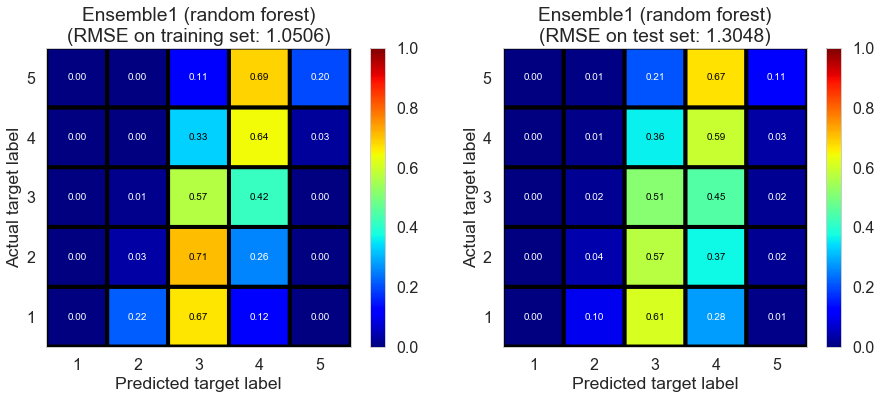

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.9007.  
            RMSE on test set: 1.1591.  
            $R^2$ on training set: 0.6043.   
            $R^2$ on test set: 0.3616.  
            Classification accuracy on training set: 0.3899.  
            Classification accuracy on test set: 0.3023.
            

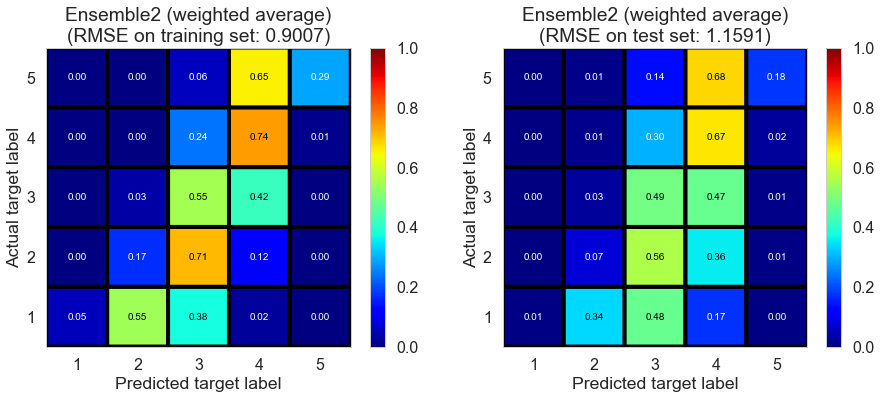

### Ensemble2 (Ridge regression)

Fitting time: 0.0040 s.  
            RMSE on training set: 1.2721.  
            RMSE on test set: 1.0830.  
            $R^2$ on training set: 0.2107.   
            $R^2$ on test set: 0.4426.  
            Classification accuracy on training set: 0.3365.  
            Classification accuracy on test set: 0.4028.
            

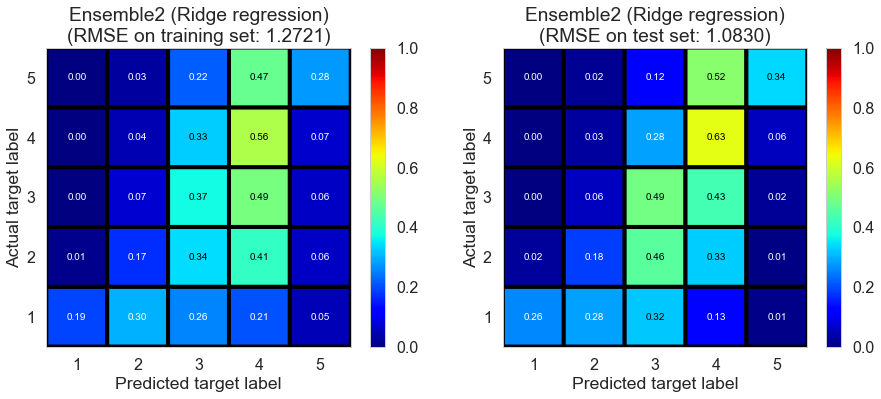

### Ensemble2 (random forest)

Fitting time: 0.2710 s.  
            RMSE on training set: 1.0678.  
            RMSE on test set: 1.0847.  
            $R^2$ on training set: 0.4439.   
            $R^2$ on test set: 0.4409.  
            Classification accuracy on training set: 0.4146.  
            Classification accuracy on test set: 0.4111.
            

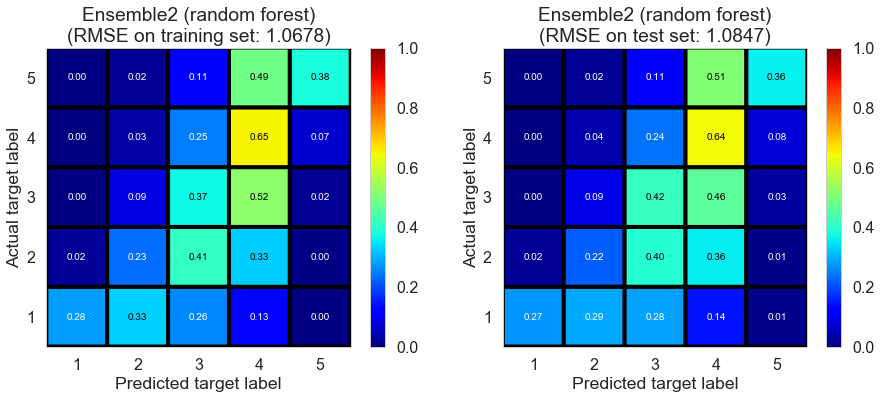


Cleveland...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7559.  
            RMSE on test set: 1.2085.  
            $R^2$ on training set: 0.6839.   
            $R^2$ on test set: 0.1955.  
            Classification accuracy on training set: 0.4950.  
            Classification accuracy on test set: 0.3021.
            

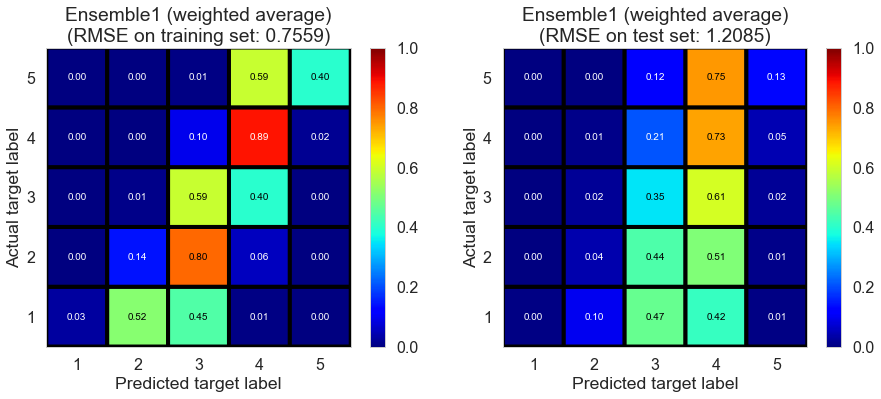

### Ensemble1 (Ridge regression)

Fitting time: 0.0050 s.  
            RMSE on training set: 0.9587.  
            RMSE on test set: 1.2040.  
            $R^2$ on training set: 0.4916.   
            $R^2$ on test set: 0.2014.  
            Classification accuracy on training set: 0.3781.  
            Classification accuracy on test set: 0.3111.
            

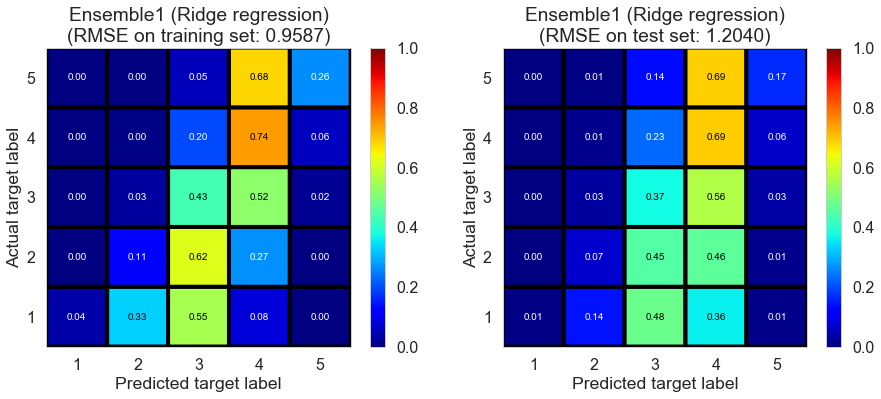

### Ensemble1 (random forest)

Fitting time: 0.7260 s.  
            RMSE on training set: 0.9431.  
            RMSE on test set: 1.2063.  
            $R^2$ on training set: 0.5080.   
            $R^2$ on test set: 0.1984.  
            Classification accuracy on training set: 0.3632.  
            Classification accuracy on test set: 0.2997.
            

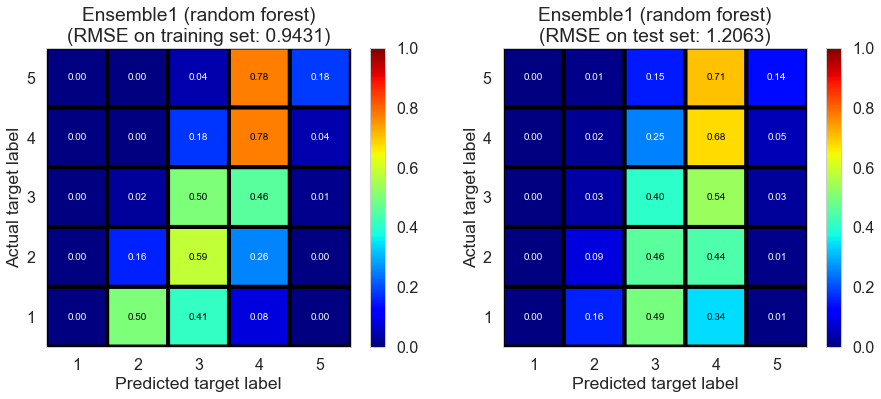

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8214.  
            RMSE on test set: 1.0915.  
            $R^2$ on training set: 0.6268.   
            $R^2$ on test set: 0.3437.  
            Classification accuracy on training set: 0.4580.  
            Classification accuracy on test set: 0.3404.
            

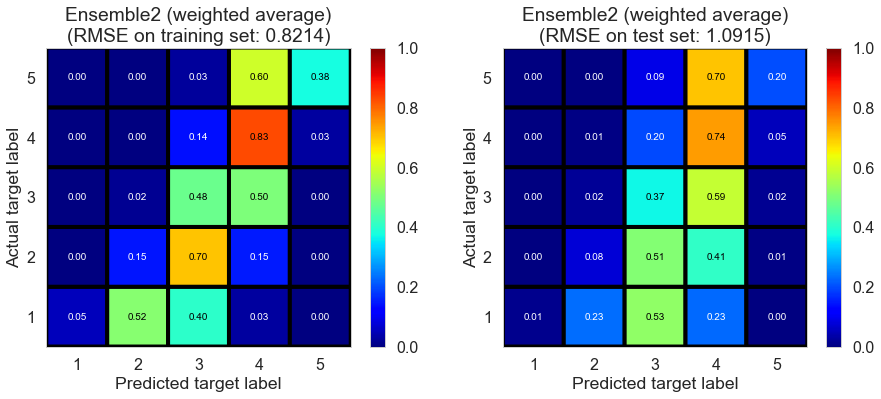

### Ensemble2 (Ridge regression)

Fitting time: 0.0070 s.  
            RMSE on training set: 1.0072.  
            RMSE on test set: 1.0141.  
            $R^2$ on training set: 0.4389.   
            $R^2$ on test set: 0.4334.  
            Classification accuracy on training set: 0.4330.  
            Classification accuracy on test set: 0.4284.
            

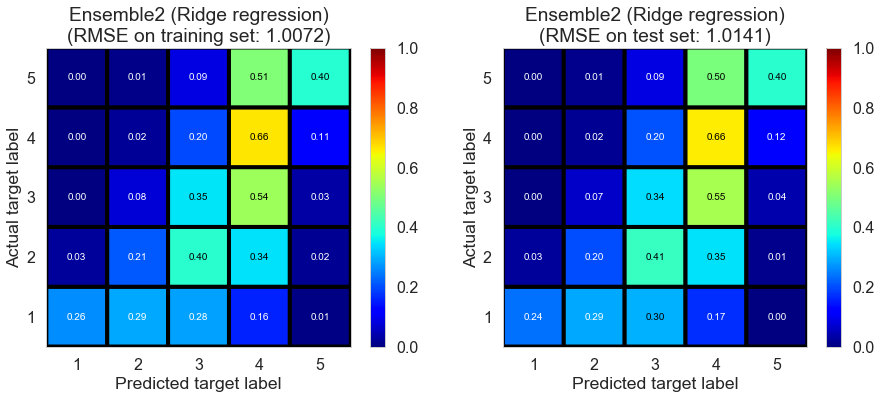

### Ensemble2 (random forest)

Fitting time: 0.9471 s.  
            RMSE on training set: 0.9989.  
            RMSE on test set: 1.0180.  
            $R^2$ on training set: 0.4480.   
            $R^2$ on test set: 0.4291.  
            Classification accuracy on training set: 0.4379.  
            Classification accuracy on test set: 0.4320.
            

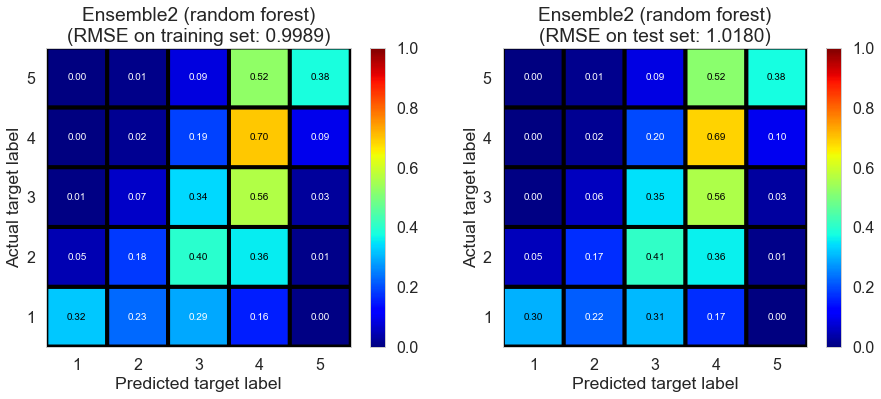


Pittsburgh...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8050.  
            RMSE on test set: 1.1919.  
            $R^2$ on training set: 0.6317.   
            $R^2$ on test set: 0.1925.  
            Classification accuracy on training set: 0.4604.  
            Classification accuracy on test set: 0.3016.
            

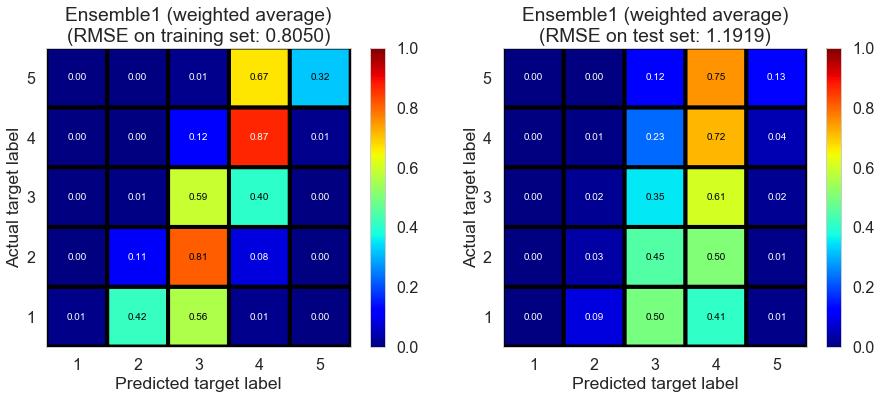

### Ensemble1 (Ridge regression)

Fitting time: 0.0150 s.  
            RMSE on training set: 0.9371.  
            RMSE on test set: 1.1872.  
            $R^2$ on training set: 0.5010.   
            $R^2$ on test set: 0.1988.  
            Classification accuracy on training set: 0.3888.  
            Classification accuracy on test set: 0.3103.
            

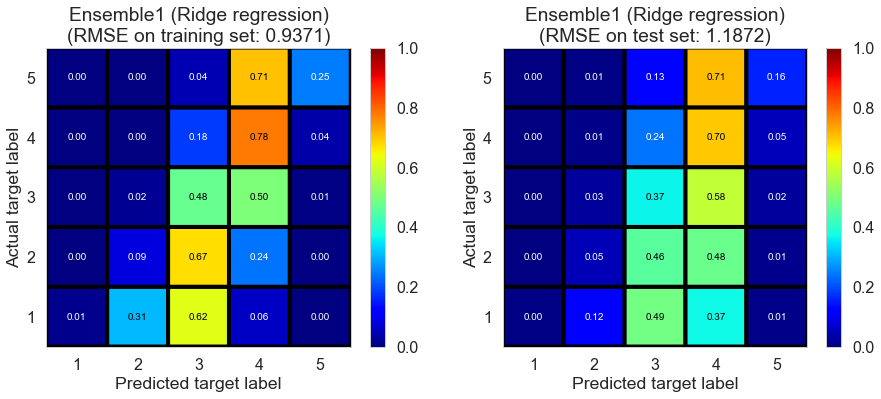

### Ensemble1 (random forest)

Fitting time: 1.2871 s.  
            RMSE on training set: 0.9703.  
            RMSE on test set: 1.1882.  
            $R^2$ on training set: 0.4650.   
            $R^2$ on test set: 0.1974.  
            Classification accuracy on training set: 0.3832.  
            Classification accuracy on test set: 0.3096.
            

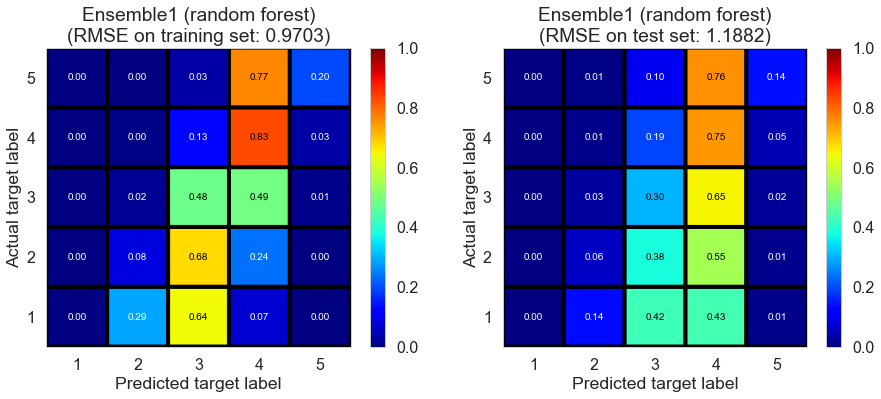

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8576.  
            RMSE on test set: 1.0612.  
            $R^2$ on training set: 0.5820.   
            $R^2$ on test set: 0.3598.  
            Classification accuracy on training set: 0.4469.  
            Classification accuracy on test set: 0.3511.
            

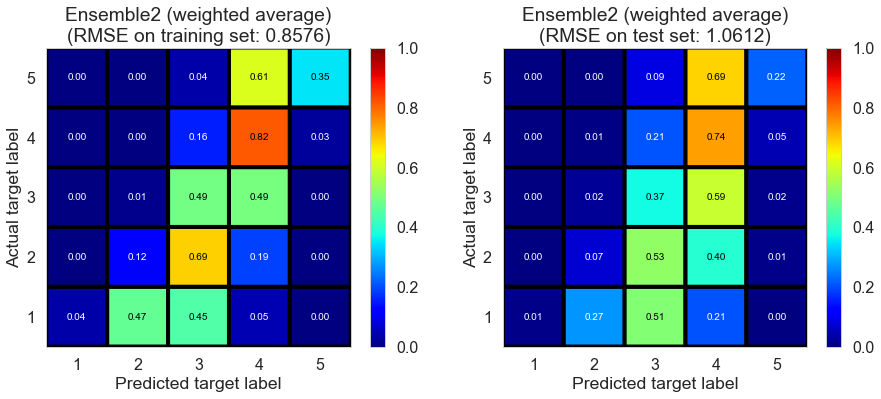

### Ensemble2 (Ridge regression)

Fitting time: 0.0170 s.  
            RMSE on training set: 0.9494.  
            RMSE on test set: 0.9882.  
            $R^2$ on training set: 0.4878.   
            $R^2$ on test set: 0.4449.  
            Classification accuracy on training set: 0.4624.  
            Classification accuracy on test set: 0.4441.
            

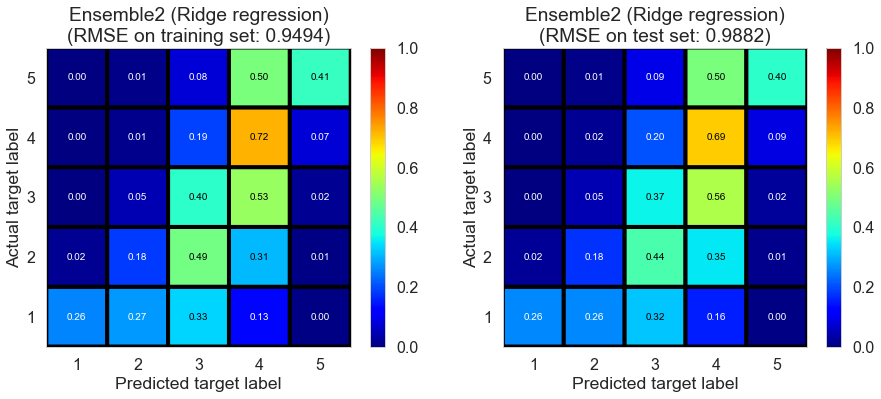

### Ensemble2 (random forest)

Fitting time: 1.7071 s.  
            RMSE on training set: 0.9996.  
            RMSE on test set: 0.9933.  
            $R^2$ on training set: 0.4322.   
            $R^2$ on test set: 0.4391.  
            Classification accuracy on training set: 0.4466.  
            Classification accuracy on test set: 0.4477.
            

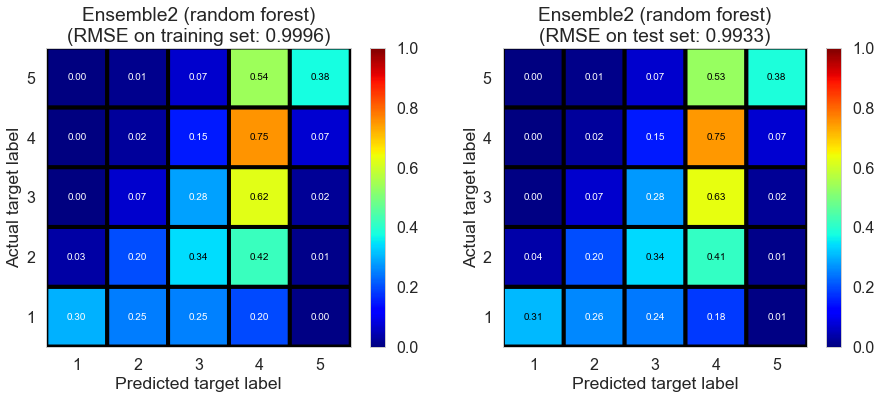


Toronto...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8044.  
            RMSE on test set: 1.1661.  
            $R^2$ on training set: 0.6136.   
            $R^2$ on test set: 0.1837.  
            Classification accuracy on training set: 0.4565.  
            Classification accuracy on test set: 0.3215.
            

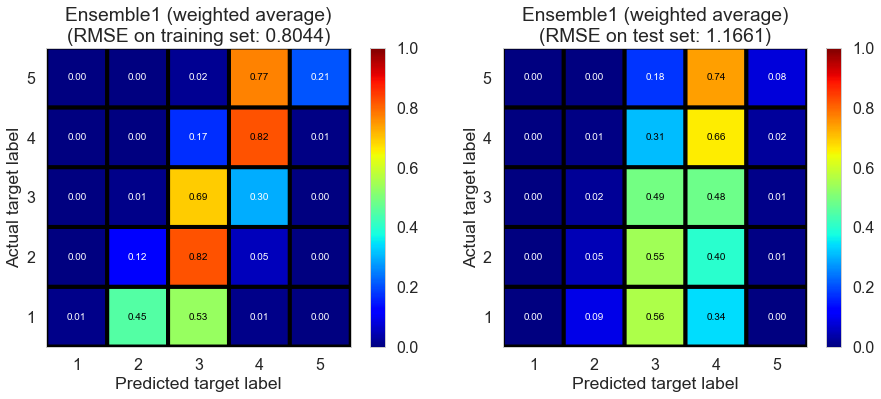

### Ensemble1 (Ridge regression)

Fitting time: 0.0290 s.  
            RMSE on training set: 1.0152.  
            RMSE on test set: 1.1620.  
            $R^2$ on training set: 0.3845.   
            $R^2$ on test set: 0.1895.  
            Classification accuracy on training set: 0.3577.  
            Classification accuracy on test set: 0.3275.
            

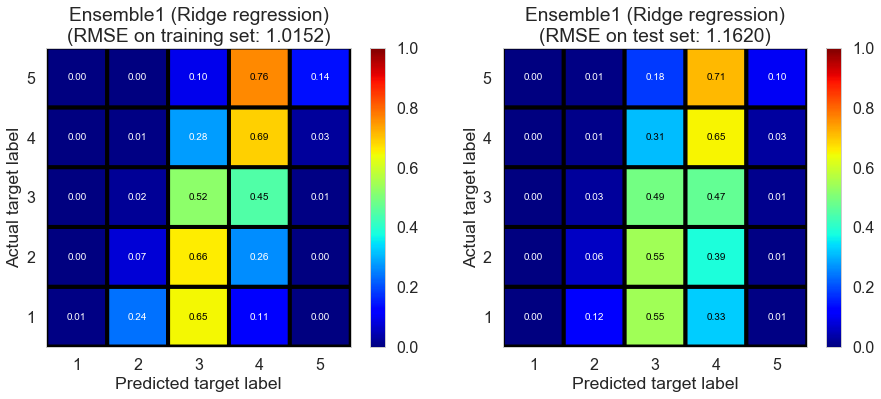

### Ensemble1 (random forest)

Fitting time: 3.2312 s.  
            RMSE on training set: 0.9977.  
            RMSE on test set: 1.1637.  
            $R^2$ on training set: 0.4056.   
            $R^2$ on test set: 0.1872.  
            Classification accuracy on training set: 0.3259.  
            Classification accuracy on test set: 0.3044.
            

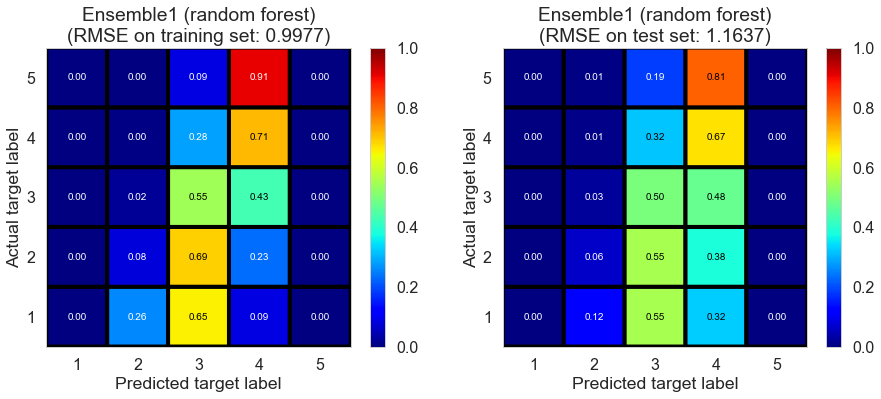

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8564.  
            RMSE on test set: 1.0542.  
            $R^2$ on training set: 0.5620.   
            $R^2$ on test set: 0.3329.  
            Classification accuracy on training set: 0.4369.  
            Classification accuracy on test set: 0.3586.
            

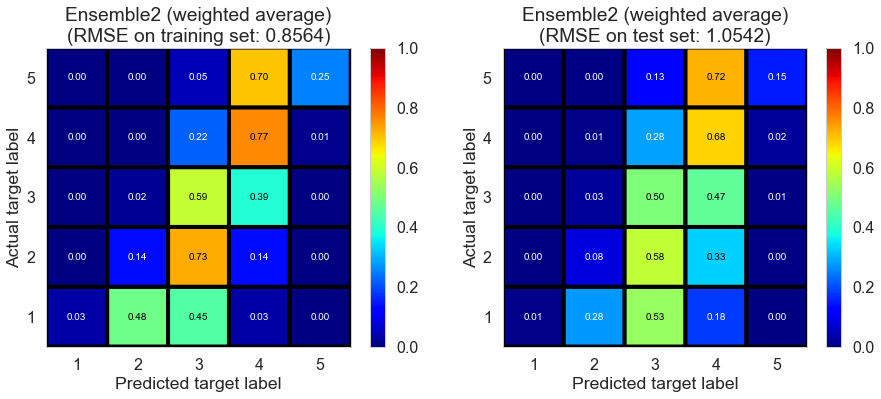

### Ensemble2 (Ridge regression)

Fitting time: 0.0390 s.  
            RMSE on training set: 1.0111.  
            RMSE on test set: 0.9879.  
            $R^2$ on training set: 0.3895.   
            $R^2$ on test set: 0.4141.  
            Classification accuracy on training set: 0.4173.  
            Classification accuracy on test set: 0.4286.
            

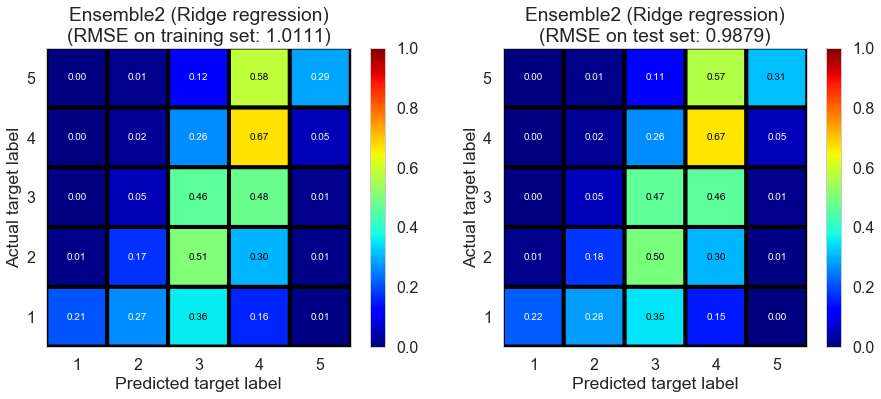

### Ensemble2 (random forest)

Fitting time: 4.1512 s.  
            RMSE on training set: 0.9948.  
            RMSE on test set: 0.9962.  
            $R^2$ on training set: 0.4090.   
            $R^2$ on test set: 0.4043.  
            Classification accuracy on training set: 0.4275.  
            Classification accuracy on test set: 0.4295.
            

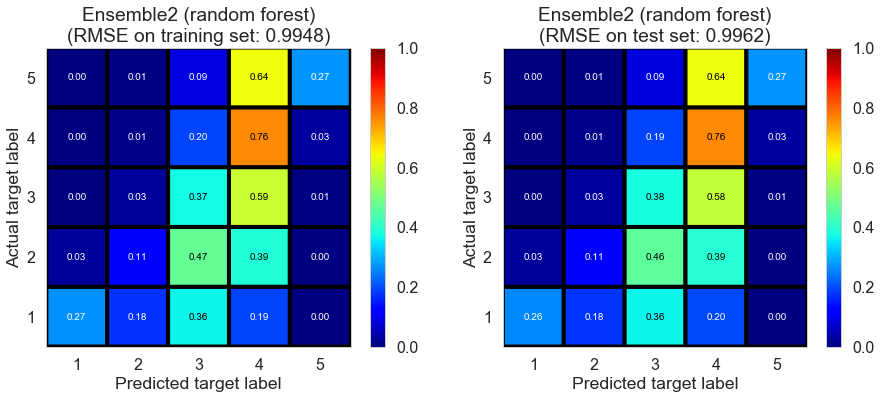


Las_Vegas...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.7633.  
            RMSE on test set: 1.2648.  
            $R^2$ on training set: 0.7185.   
            $R^2$ on test set: 0.2270.  
            Classification accuracy on training set: 0.4952.  
            Classification accuracy on test set: 0.2842.
            

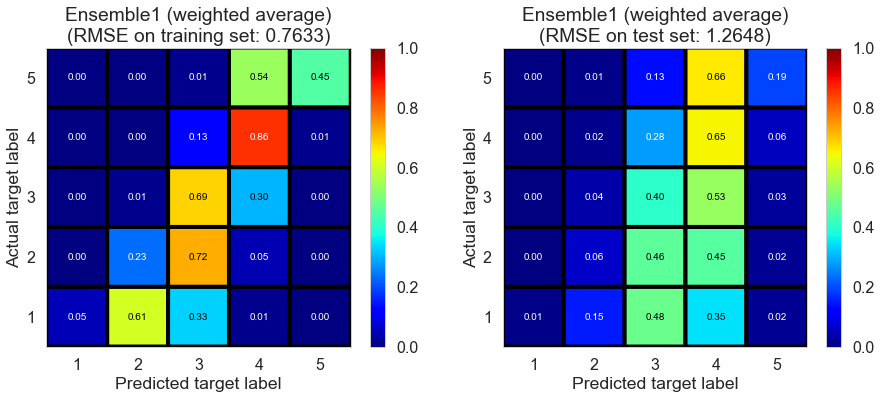

### Ensemble1 (Ridge regression)

Fitting time: 0.1270 s.  
            RMSE on training set: 1.0514.  
            RMSE on test set: 1.2600.  
            $R^2$ on training set: 0.4660.   
            $R^2$ on test set: 0.2329.  
            Classification accuracy on training set: 0.3616.  
            Classification accuracy on test set: 0.2987.
            

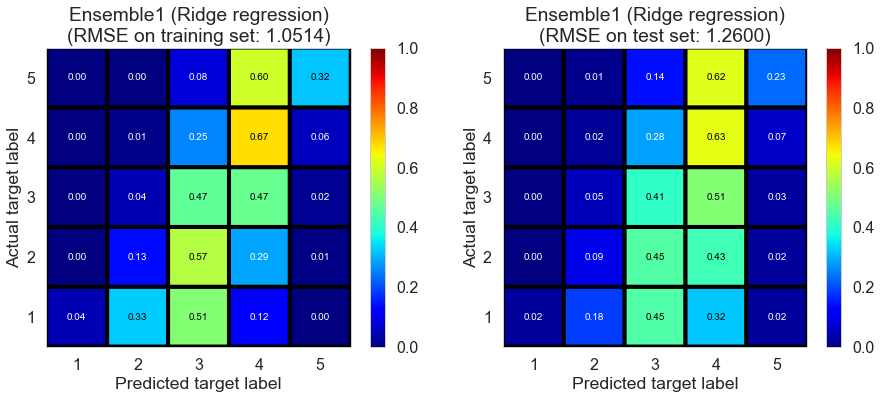

### Ensemble1 (random forest)

Fitting time: 13.2948 s.  
            RMSE on training set: 1.0838.  
            RMSE on test set: 1.2617.  
            $R^2$ on training set: 0.4326.   
            $R^2$ on test set: 0.2308.  
            Classification accuracy on training set: 0.3527.  
            Classification accuracy on test set: 0.3016.
            

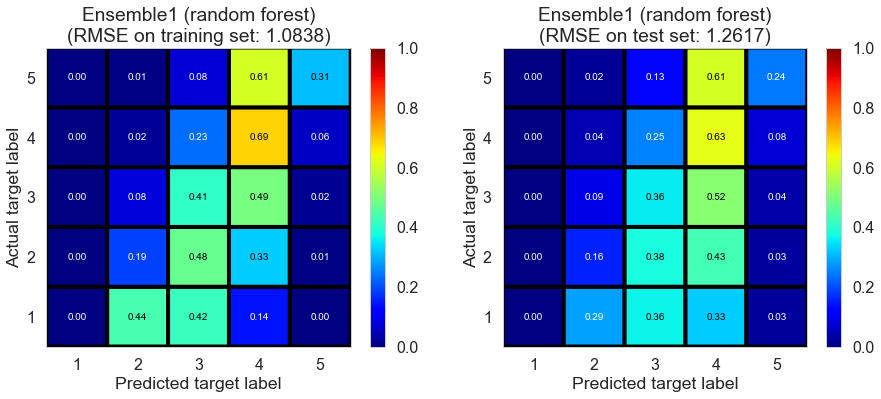

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8674.  
            RMSE on test set: 1.1697.  
            $R^2$ on training set: 0.6366.   
            $R^2$ on test set: 0.3389.  
            Classification accuracy on training set: 0.4417.  
            Classification accuracy on test set: 0.3209.
            

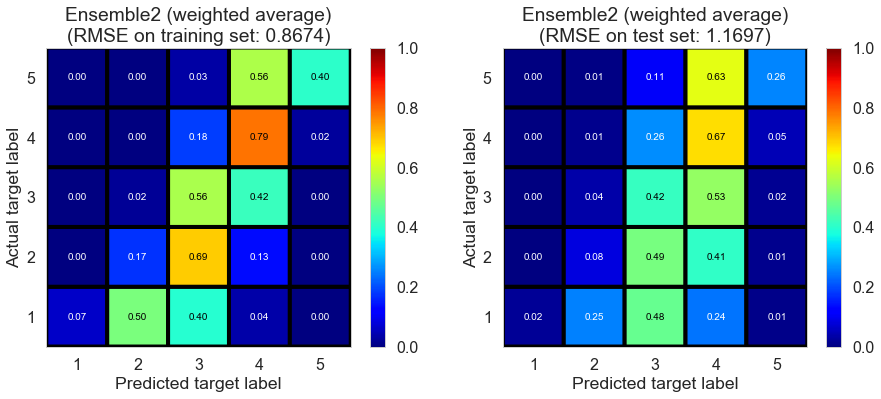

### Ensemble2 (Ridge regression)

Fitting time: 0.1520 s.  
            RMSE on training set: 1.1144.  
            RMSE on test set: 1.1016.  
            $R^2$ on training set: 0.4001.   
            $R^2$ on test set: 0.4136.  
            Classification accuracy on training set: 0.4072.  
            Classification accuracy on test set: 0.4138.
            

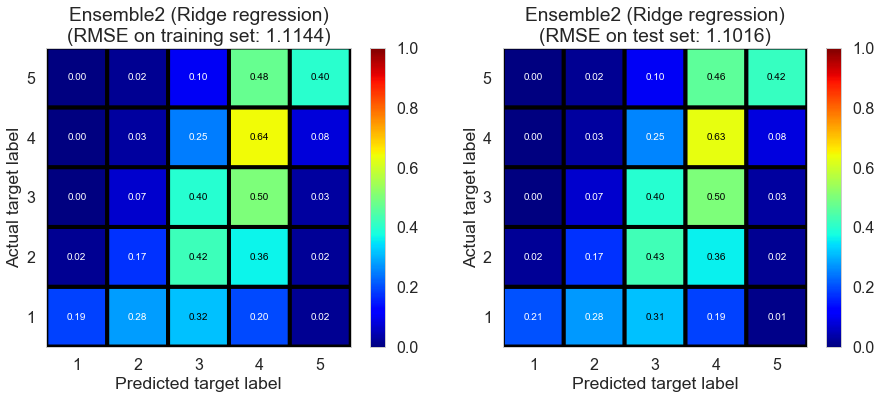

### Ensemble2 (random forest)

Fitting time: 16.9300 s.  
            RMSE on training set: 1.1061.  
            RMSE on test set: 1.1082.  
            $R^2$ on training set: 0.4090.   
            $R^2$ on test set: 0.4066.  
            Classification accuracy on training set: 0.3985.  
            Classification accuracy on test set: 0.3983.
            

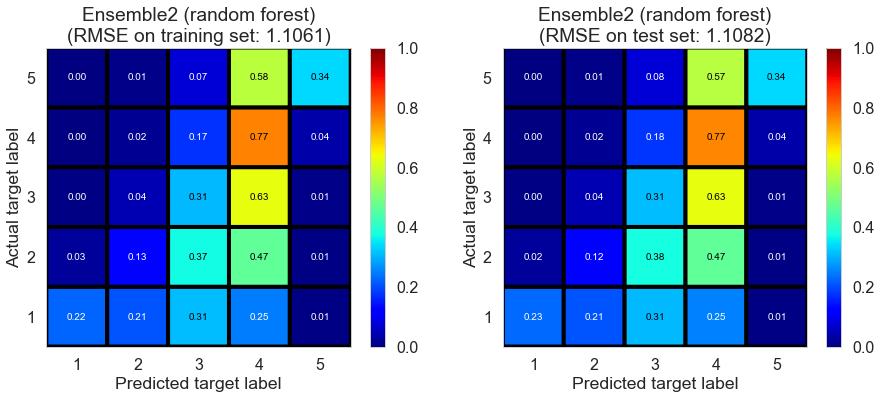


Full...


### Ensemble1 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8161.  
            RMSE on test set: 1.2572.  
            $R^2$ on training set: 0.6706.   
            $R^2$ on test set: 0.2195.  
            Classification accuracy on training set: 0.4567.  
            Classification accuracy on test set: 0.2876.
            

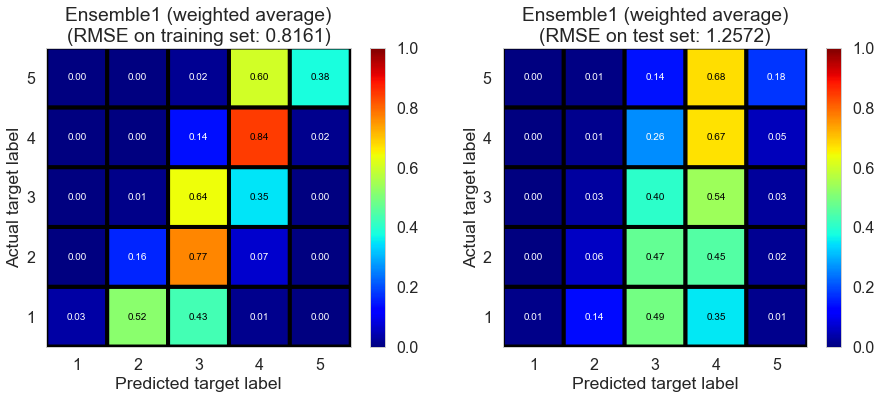

### Ensemble1 (Ridge regression)

Fitting time: 0.4160 s.  
            RMSE on training set: 1.0550.  
            RMSE on test set: 1.2520.  
            $R^2$ on training set: 0.4496.   
            $R^2$ on test set: 0.2260.  
            Classification accuracy on training set: 0.3556.  
            Classification accuracy on test set: 0.3021.
            

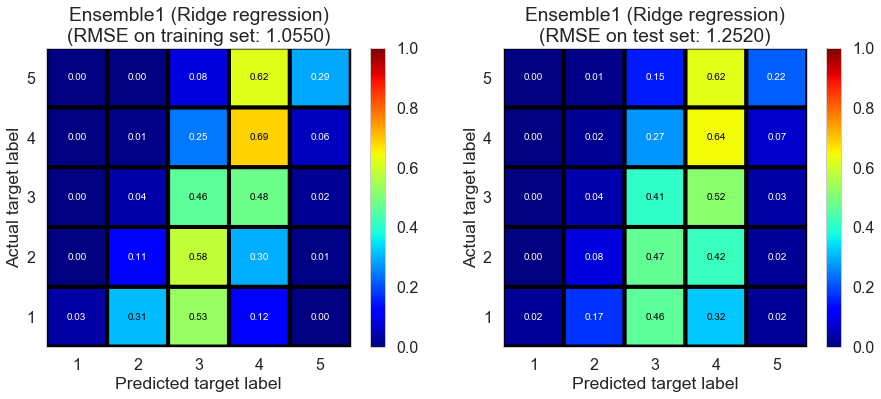

### Ensemble1 (random forest)

Fitting time: 56.0282 s.  
            RMSE on training set: 1.0652.  
            RMSE on test set: 1.2542.  
            $R^2$ on training set: 0.4389.   
            $R^2$ on test set: 0.2233.  
            Classification accuracy on training set: 0.3418.  
            Classification accuracy on test set: 0.2958.
            

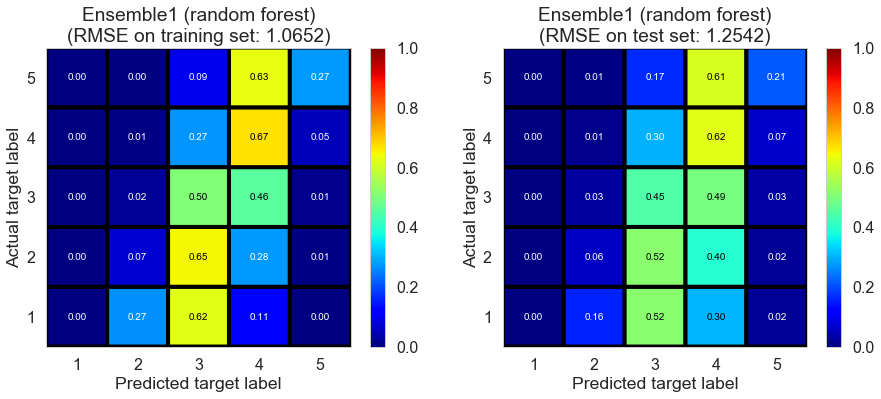

### Ensemble2 (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8864.  
            RMSE on test set: 1.1434.  
            $R^2$ on training set: 0.6115.   
            $R^2$ on test set: 0.3545.  
            Classification accuracy on training set: 0.4346.  
            Classification accuracy on test set: 0.3305.
            

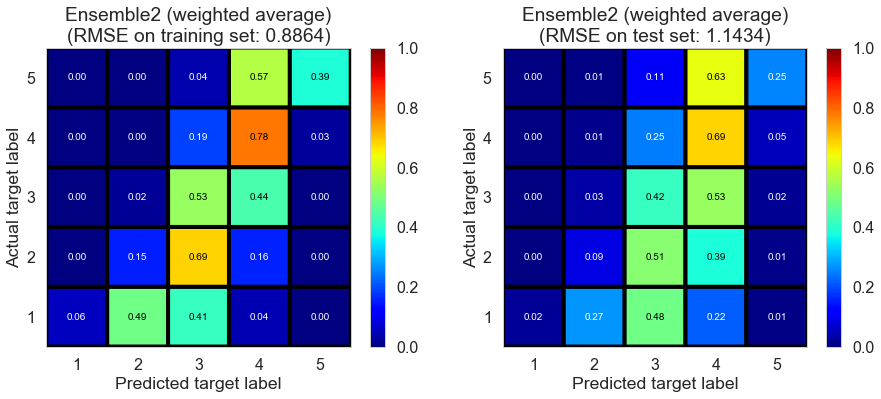

### Ensemble2 (Ridge regression)

Fitting time: 0.5530 s.  
            RMSE on training set: 1.0865.  
            RMSE on test set: 1.0623.  
            $R^2$ on training set: 0.4163.   
            $R^2$ on test set: 0.4427.  
            Classification accuracy on training set: 0.4230.  
            Classification accuracy on test set: 0.4320.
            

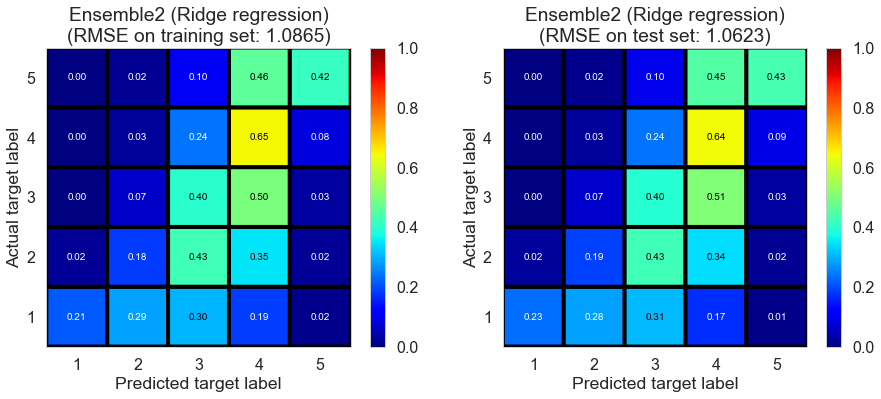

### Ensemble2 (random forest)

Fitting time: 69.6950 s.  
            RMSE on training set: 1.0689.  
            RMSE on test set: 1.0703.  
            $R^2$ on training set: 0.4351.   
            $R^2$ on test set: 0.4343.  
            Classification accuracy on training set: 0.4239.  
            Classification accuracy on test set: 0.4229.
            

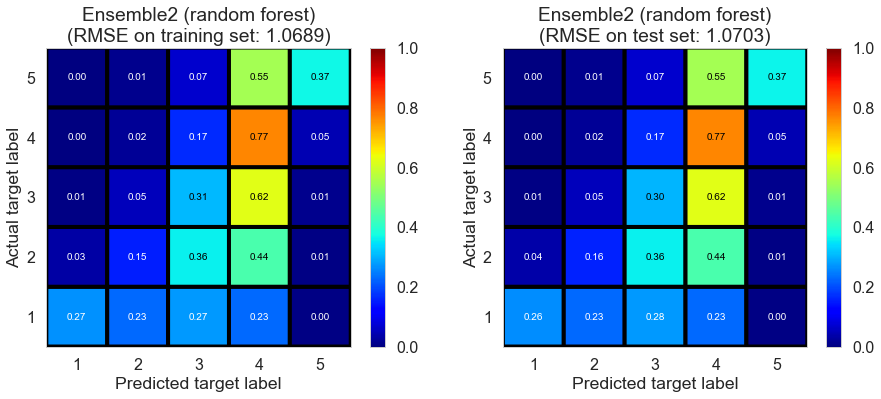


Wall time: 41.4 s


In [8]:
%%time

for city in cities:
    print(city + '...')
    data_dir = 'data/{}/'.format(city)
    is_successful = IO(data_dir + 'results06/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results06/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results06/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results06/results.pkl').read_pickle()
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

    for i in range(len(is_successful)):
        if is_successful[i]:
            model = IO(datanames[i]).read_pickle()
            show_results(model, model_names[i], None, y_train, None, y_test, results=results[i], show_cv=False)
            del model